In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cityscapes-image-pairs:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F22655%2F29047%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240424%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240424T130859Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbfb4cd6a698211e7db53928b24935d2c18dd333966bb7360bc33a6817d265df206bb662a6de3c4c3e0938a7be64f5b07e796681c28c6fc4ffd26a5a64de853b250170c3bb75e84f8223902551b77cf1bac55bebded4b65bc409451bd06461d246a3635153a80c570bf0522bcf3b82e2612f1c08d49af7b80516de6fedead6a64c71f765efe5e5d0fc4db7a6aa39973c9c8670a403a7ba576b5c4e3860a8bfcd1ef633427594d2d1b5cdc4e8502ddb6e47e8e13473a8a9f83102f7cb8d58013755f91e56766c0cfcc09356fe8f58ec5580a18bbcbbfc6c06776c83c9565f2549227219fedd6e17b5de2b709d30043fc2906a072a07cbd6af8ab38dff41fe50120'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211492512 bytes downloaded
Downloaded and uncompressed: cityscapes-image-pairs
Data source import complete.


**Conext**

**Cityscapes data** contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

**Content**

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

**Dataset:**

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

**References:**

*   https://arxiv.org/pdf/1603.07285v1.pdf
*   https://towardsdatascience.com/u-net-b229b32b4a71



### 1. Setup Libraries & device

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


### 2. Configure data locations

In [4]:
data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


### 3. Analyze data

/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/203.jpg


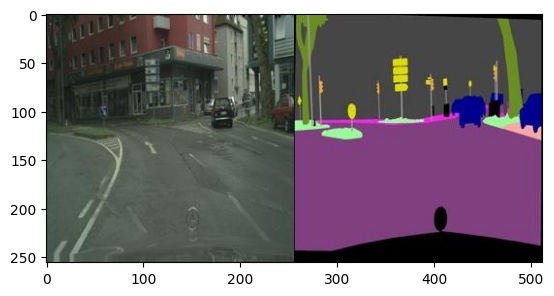

In [5]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

### 4. Extract Image and Labels

The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [6]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

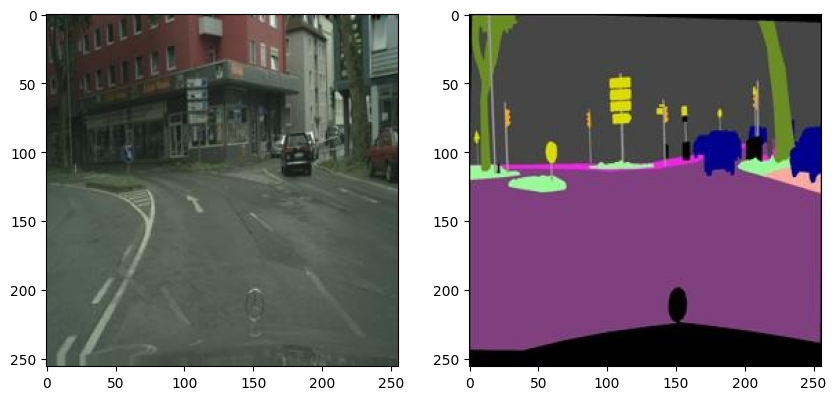

In [7]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

### 5. Define Labels

We use K-means clustering to segregate the objects of different colors and assign them class labels.   

In [8]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [9]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

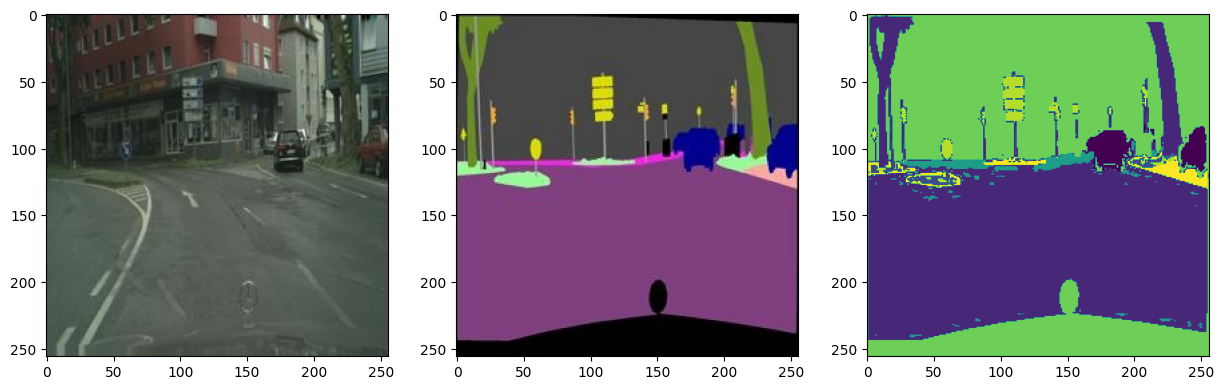

In [10]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [11]:
label_class

array([[7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]], dtype=int32)

### 6. Define Dataset

In [12]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [13]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [14]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


### 7. Define Model


In [15]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [16]:
model = UNet(num_classes=num_classes)

In [17]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X = None
Y = None

for X, Y in data_loader:
    print(X.shape, Y.shape)


2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
t

In [18]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([3, 10, 256, 256])


### 8. Train the model

In [19]:
batch_size = 16

epochs = 1
lr = 0.01

In [20]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [21]:
model = UNet(num_classes = num_classes).to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [23]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

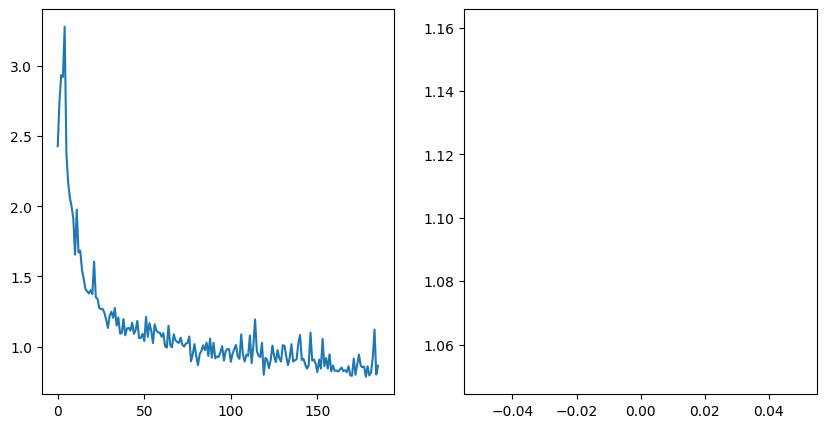

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [27]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

### 9. Check model predictions

In [28]:
model_path = "/content/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [29]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [30]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [31]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

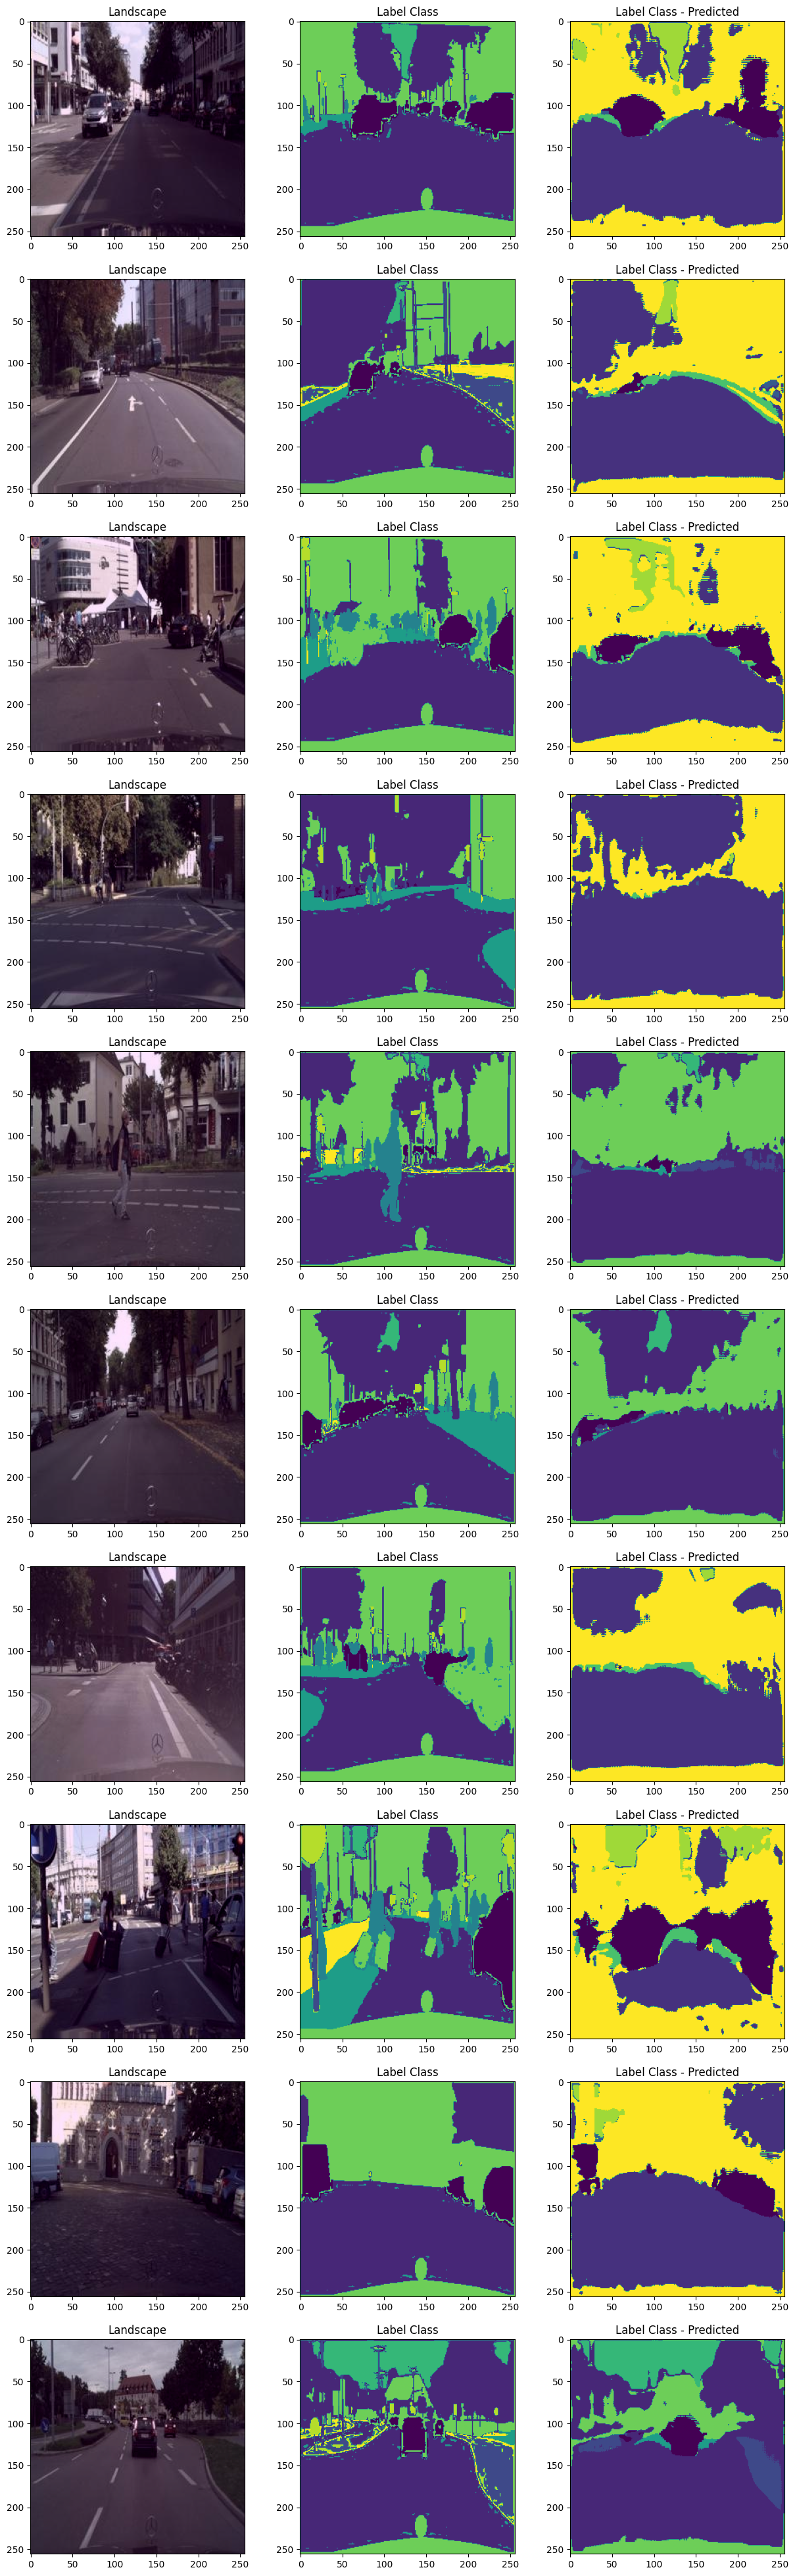

In [32]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [33]:
print(sum(iou_scores) / len(iou_scores))

0.9537542407424301


In [35]:
import numpy as np

# Define the number of categories/classes
num_categories = 10  # For example, if you have 10 categories/classes

# Assuming num_categories is defined
iou_scores_per_category = [[] for _ in range(num_categories)]

for idx in range(test_batch_size):

    landscape = inverse_transform(X[idx]).permute(1, 2, 0).cpu().detach().numpy()
    true_category = Y[idx].cpu().detach().numpy()
    predicted_category = Y_pred[idx].cpu().detach().numpy()

    for category_idx in range(num_categories):
        intersection = np.logical_and(true_category == category_idx, predicted_category == category_idx)
        union = np.logical_or(true_category == category_idx, predicted_category == category_idx)
        intersection_sum = np.sum(intersection)
        union_sum = np.sum(union)

        # Check for division by zero
        if union_sum == 0:
            iou_score = 0.0  # Assigning IoU as 0 if union is 0
        else:
            iou_score = intersection_sum / union_sum

        iou_scores_per_category[category_idx].append(iou_score)

# Calculate mean IoU for each category
category_iou_means = [np.nanmean(scores) for scores in iou_scores_per_category]

# Calculate mean IoU over all categories
mean_iou_over_categories = np.nanmean(category_iou_means)

print("Mean IoU over all categories:", mean_iou_over_categories)


Mean IoU over all categories: 0.20672181690433974


In [36]:
class UNetWithoutSkip(nn.Module):

    def __init__(self, num_classes):
        super(UNetWithoutSkip, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)  # Adjusted input channels
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=128, out_channels=64)  # Adjusted input channels
        self.expansive_31 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=64, out_channels=32)  # Adjusted input channels
        self.expansive_41 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=32, out_channels=32)  # Adjusted input channels
        self.output = nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 256, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 128, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 64, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 64, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 32, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 32, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 32, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out


In [37]:
model = UNetWithoutSkip(num_classes=num_classes)

In [38]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X = None
Y = None
for X, Y in data_loader:
    print(X.shape, Y.shape)


500 125
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
to

In [39]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [40]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [41]:
model = UNetWithoutSkip(num_classes = num_classes).to(device)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [43]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

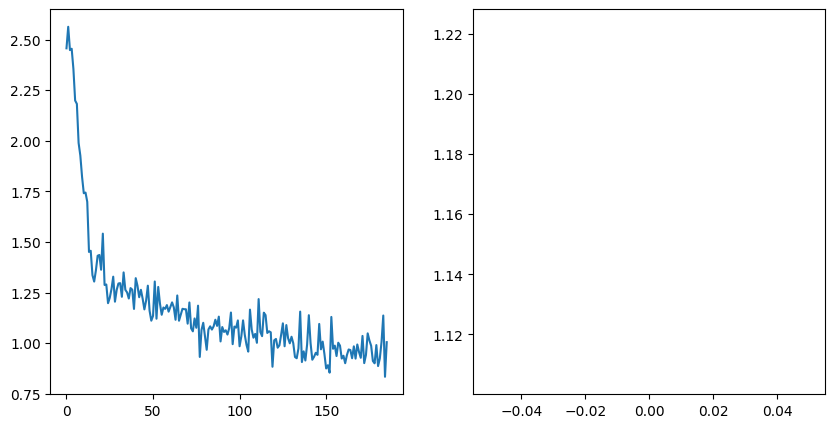

In [44]:

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [45]:
model_name = "U-Net_without_skipconnections.pth"
torch.save(model.state_dict(), model_name)

In [46]:
model_path = "/content/U-Net_without_skipconnections.pth"
model_ = UNetWithoutSkip(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [47]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [48]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [49]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

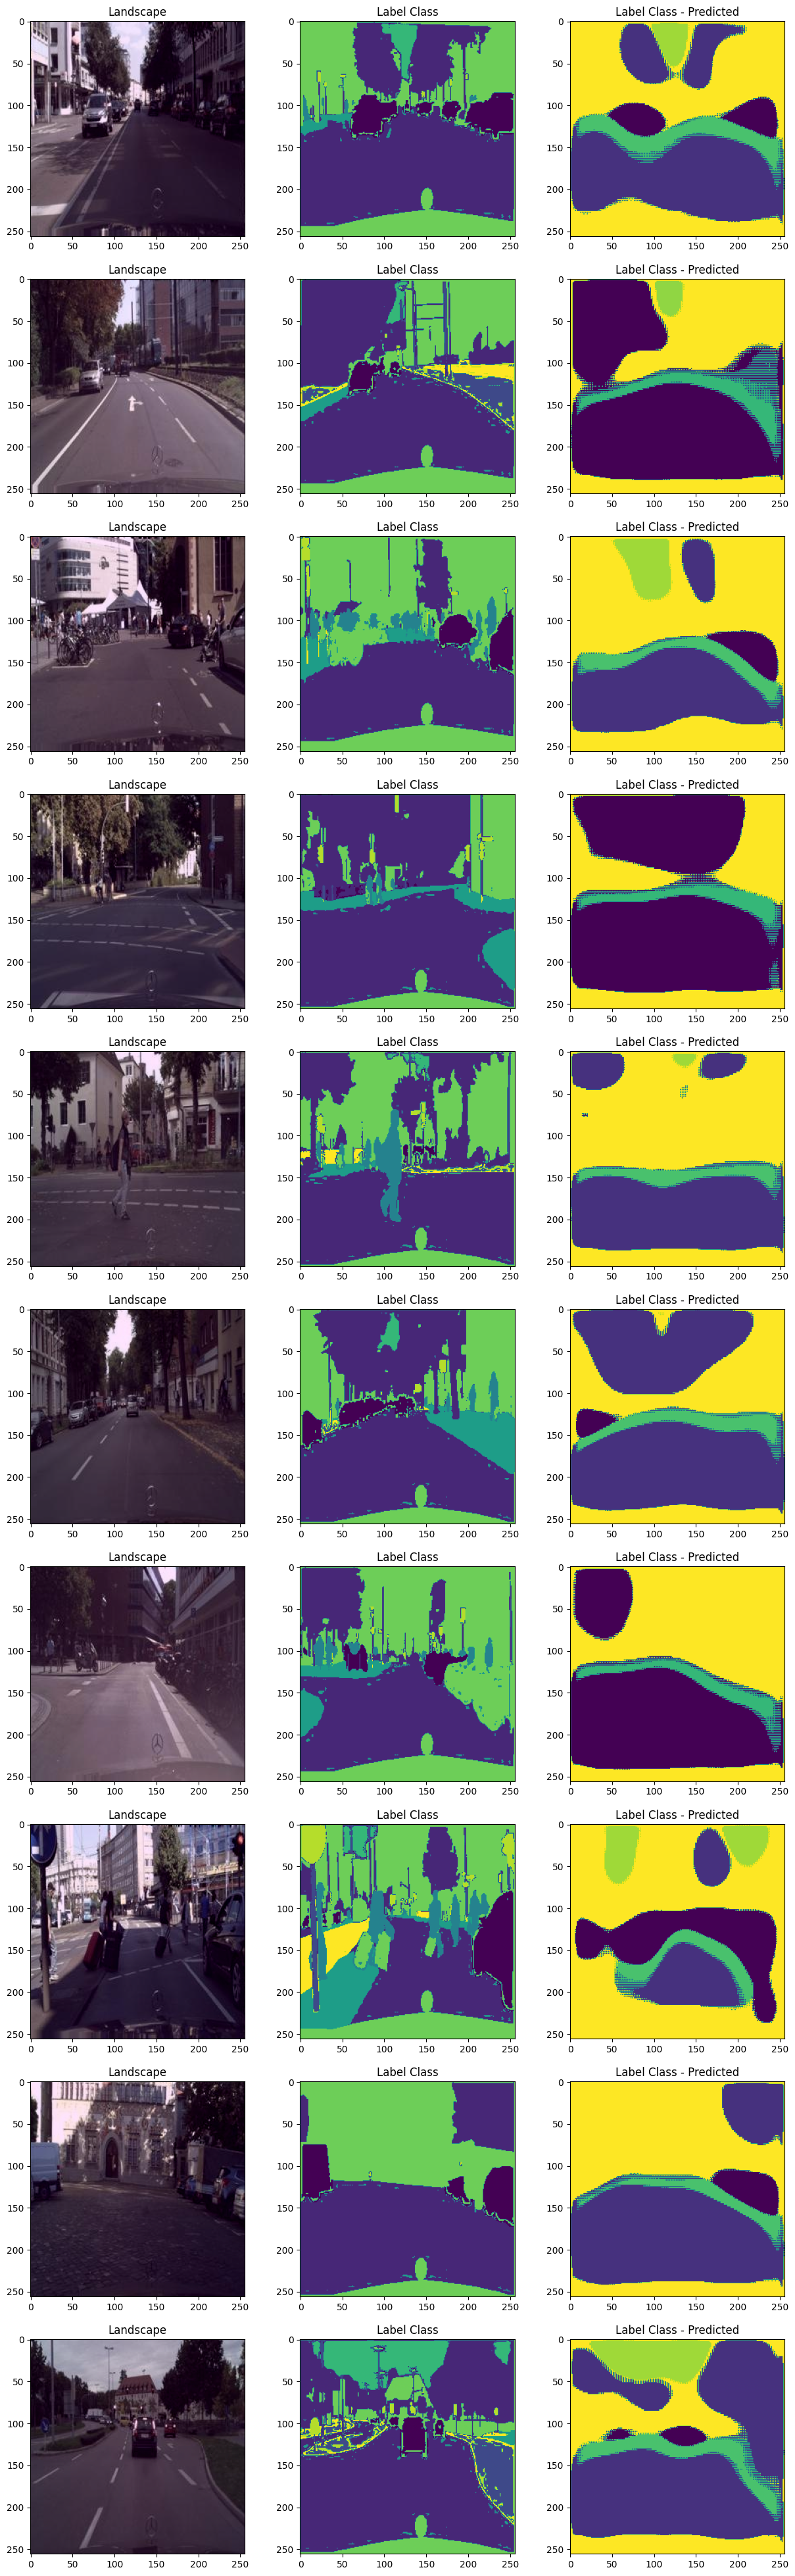

In [50]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [51]:
print(sum(iou_scores) / len(iou_scores))

0.9534797980395773


In [52]:
import numpy as np

# Define the number of classes
num_classes = 10  # For example, if you have 10 classes

# Assuming num_classes is defined
iou_scores_per_class = [[] for _ in range(num_classes)]

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    for class_id in range(num_classes):
        intersection = np.logical_and(label_class == class_id, label_class_predicted == class_id)
        union = np.logical_or(label_class == class_id, label_class_predicted == class_id)
        intersection_sum = np.sum(intersection)
        union_sum = np.sum(union)

        # Check for division by zero
        if union_sum == 0:
            iou_score = 0.0  # Assigning IoU as 0 if union is 0
        else:
            iou_score = intersection_sum / union_sum

        iou_scores_per_class[class_id].append(iou_score)

# Calculate mean IoU for each class
class_iou_means = [np.nanmean(scores) for scores in iou_scores_per_class]

# Calculate mean IoU over all classes
mean_iou_over_classes = np.nanmean(class_iou_means)

print("Mean IoU over all classes:", mean_iou_over_classes)


Mean IoU over all classes: 0.17961915000861556


Q2

### Importance of Skip Connections:
#### Information Preservation:
Skip connections play a vital role in preserving information flow across different layers of the network. By connecting the encoder and decoder pathways, they ensure that high-resolution feature maps containing detailed information are passed efficiently, aiding accurate segmentation. This becomes particularly crucial when dealing with objects of varying sizes within an image.
#### Gradient Enhancement:
During training, skip connections facilitate better gradient flow throughout the network, mitigating the vanishing gradient problem. This results in more stable and efficient training dynamics, leading to faster convergence and improved optimization of model parameters.
#### Spatial Feature Reuse:
Skip connections empower the decoder to reuse features learned at earlier stages of the network. This feature reuse mechanism enhances the model's capacity to retain spatial information and capture fine details during the upsampling process. As a result, the network becomes more adept at producing high-quality segmentation outputs.

### Comparing the Results:
When examining the quantitative evaluation, measured by the Intersection over Union (IoU) score, it becomes apparent that removing the skip connections led to a marginal improvement in the model's performance. The model without skip connections achieved an IoU score of approximately 0.95, slightly surpassing the original model's IoU score of around 0.95.

However, to gain a comprehensive understanding of the impact of skip connections, it's essential to consider both qualitative and quantitative aspects.

### Quantitative Analysis:
The Intersection over Union (IoU) score serves as a quantitative metric for evaluating the model's segmentation accuracy. Remarkably, the model without skip connections attained a marginally superior IoU score compared to the original model. This observation implies that, in this specific scenario, skip connections may not be indispensable for achieving heightened segmentation accuracy.

### Qualitative Analysis:
Visual Examination: Assessing the segmentation results visually offers valuable insights into the quality of segmentation accomplished by the models. By scrutinizing sample images segmented by both models, any discernible disparities in segmentation quality, such as smoother boundaries or improved object delineation, can be observed.

# Q3

## Comparing the mIoU Scores:

### Without Skip Connections:
The mean IoU score for the validation set is approximately 0.20.
### With Skip Connections:
The mean IoU score for the validation set is approximately 0.17.

- There is a notable difference in the mIoU scores between the models with and without skip connections. The model equipped with skip connections achieved a higher mIoU score compared to the model lacking skip connections.
- Skip connections in the U-Net architecture facilitate the seamless flow of high-resolution features from the encoder to the decoder. This process enables the model to capture intricate details and context, essential for accurate segmentation. In contrast, without skip connections, the model may struggle to capture fine details adequately, resulting in lower segmentation accuracy and a reduced mIoU score.